In [1]:
import diffuser.utils as utils
import pdb

%precision 3
import random
import numpy as np
np.set_printoptions(suppress=True)

pybullet build time: May 20 2022 19:44:17


In [2]:
from matplotlib import pyplot as plt

In [3]:
class Parser(utils.Parser):
    dataset: str = 'maze2d-large-v1'
    config: str = 'config.maze2d'

args = Parser().parse_args('diffusion')

dataset_config = utils.Config(
    args.loader,
    savepath=(args.savepath, 'dataset_config.pkl'),
    env=args.dataset,
    horizon=args.horizon,
    normalizer=args.normalizer,
    preprocess_fns=args.preprocess_fns,
    use_padding=args.use_padding,
    max_path_length=args.max_path_length,
)

dataset = dataset_config()

render_config = utils.Config(
    args.renderer,
    savepath=(args.savepath, 'render_config.pkl'),
    env=args.dataset,
)

renderer = render_config()

[ utils/setup ] Reading config: config.maze2d:maze2d_large_v1
[ utils/setup ] Using overrides | config: config.maze2d | dataset: maze2d_large_v1
[ utils/setup ] Found extras: ['-f', '/home/felixw/.local/share/jupyter/runtime/kernel-a76b8ab8-acf9-4a4a-a756-0554be8a950d.json']
[ utils/setup ] Setting exp_name to: diffusion/H128_T16
[ utils/setup ] Saved args to logs/maze2d-large-v1/diffusion/H128_T16/args.json
[ utils/config ] Imported diffuser.datasets:GoalDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.GoalDataset'>
    env: maze2d-large-v1
    horizon: 128
    max_path_length: 40000
    normalizer: LimitsNormalizer
    preprocess_fns: ['maze2d_set_terminals']
    use_padding: False

[ utils/config ] Saved config to: logs/maze2d-large-v1/diffusion/H128_T16/dataset_config.pkl

[ utils/preprocessing ] Segmented maze2d-large-v1 | 1061 paths | min length: 17 | max length: 7617
[ datasets/buffer ] Finalized replay buffer | 1062 episodes
[ datasets/buffer ] Fields:
    ac

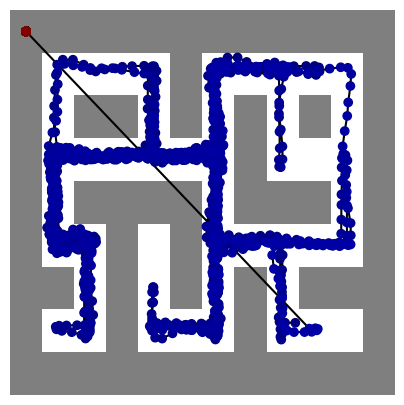

In [46]:
traj = dataset.fields.observations[6]
renderer.renders(traj);
# idx = random.randint(0, len(dataset['observations']))
# renderer.renders(dataset['observations'][idx:idx+1000]);

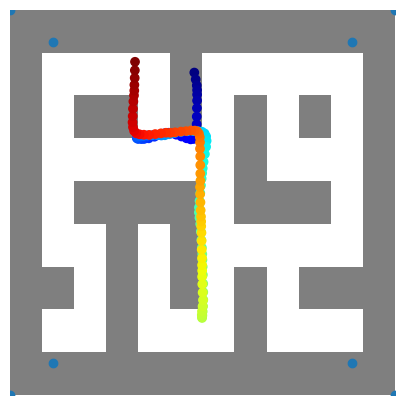

In [30]:
idx = random.randint(0, len(dataset))
renderer.renders(dataset.normalizer.unnormalize(dataset[idx].trajectories[:, 2:],'observations'));

In [56]:
dataset.normalizer.unnormalize(dataset[idx].trajectories[:, 2:],'observations')[:, 0].min()

2.715943

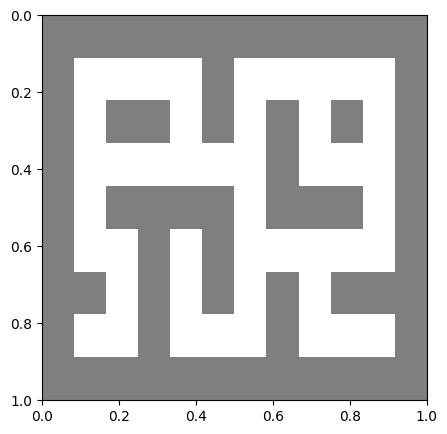

In [60]:
fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.imshow(renderer._background * .5,
    extent=renderer._extent, cmap=plt.cm.binary, vmin=0, vmax=1)

In [51]:
renderer._background.shape

(9, 12)

In [13]:
``dataset.keys()

dict_keys(['actions', 'infos/goal', 'infos/qpos', 'infos/qvel', 'observations', 'rewards', 'terminals', 'timeouts'])

In [16]:
for k, w in dataset.items():
    print(w.shape)

(4000000, 2)
(4000000, 2)
(4000000, 2)
(4000000, 2)
(4000000, 4)
(4000000,)
(4000000,)
(4000000,)


In [128]:
dataset['observations'].shape

(4000000, 4)

In [40]:
observation_dim = dataset.observation_dim
action_dim = dataset.action_dim

In [42]:
model_config = utils.Config(
    args.model,
    savepath=(args.savepath, 'model_config.pkl'),
    horizon=args.horizon,
    transition_dim=observation_dim + action_dim,
    cond_dim=observation_dim,
    dim_mults=args.dim_mults,
    device=args.device,
)

[ utils/config ] Imported diffuser.models:TemporalUnet

[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnet'>
    cond_dim: 4
    dim_mults: (1, 4, 8)
    horizon: 384
    transition_dim: 6

[ utils/config ] Saved config to: logs/maze2d-large-v1/diffusion/H384_T256/model_config.pkl



In [43]:
model = model_config()

[ models/temporal ] Channel dimensions: [(6, 32), (32, 128), (128, 256)]
[(6, 32), (32, 128), (128, 256)]


In [45]:
model_config.keys

<bound method Mapping.keys of 
[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnet'>
    cond_dim: 4
    dim_mults: (1, 4, 8)
    horizon: 384
    transition_dim: 6
>

In [57]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

3682118

In [58]:
diffusion_config = utils.Config(
    args.diffusion,
    savepath=(args.savepath, 'diffusion_config.pkl'),
    horizon=args.horizon,
    observation_dim=observation_dim,
    action_dim=action_dim,
    n_timesteps=args.n_diffusion_steps,
    loss_type=args.loss_type,
    clip_denoised=args.clip_denoised,
    predict_epsilon=args.predict_epsilon,
    ## loss weighting
    action_weight=args.action_weight,
    loss_weights=args.loss_weights,
    loss_discount=args.loss_discount,
    device=args.device,
)

[ utils/config ] Imported diffuser.models:GaussianDiffusion

[utils/config ] Config: <class 'diffuser.models.diffusion.GaussianDiffusion'>
    action_dim: 2
    action_weight: 1
    clip_denoised: True
    horizon: 384
    loss_discount: 1
    loss_type: l2
    loss_weights: None
    n_timesteps: 256
    observation_dim: 4
    predict_epsilon: False

[ utils/config ] Saved config to: logs/maze2d-large-v1/diffusion/H384_T256/diffusion_config.pkl



In [63]:
diffusion = diffusion_config(model)

In [61]:
trainer_config = utils.Config(
    utils.Trainer,
    savepath=(args.savepath, 'trainer_config.pkl'),
    train_batch_size=args.batch_size,
    train_lr=args.learning_rate,
    gradient_accumulate_every=args.gradient_accumulate_every,
    ema_decay=args.ema_decay,
    sample_freq=args.sample_freq,
    save_freq=args.save_freq,
    label_freq=int(args.n_train_steps // args.n_saves),
    save_parallel=args.save_parallel,
    results_folder=args.savepath,
    bucket=args.bucket,
    n_reference=args.n_reference,
    n_samples=args.n_samples,
)


[utils/config ] Config: <class 'diffuser.utils.training.Trainer'>
    bucket: None
    ema_decay: 0.995
    gradient_accumulate_every: 2
    label_freq: 40000
    n_reference: 50
    n_samples: 10
    results_folder: logs/maze2d-large-v1/diffusion/H384_T256
    sample_freq: 1000
    save_freq: 1000
    save_parallel: False
    train_batch_size: 32
    train_lr: 0.0002

[ utils/config ] Saved config to: logs/maze2d-large-v1/diffusion/H384_T256/trainer_config.pkl



In [64]:
trainer = trainer_config(diffusion, dataset, renderer)

In [65]:
utils.report_parameters(model)

[ utils/arrays ] Total parameters: 3.68 M
         downs.2.0.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         downs.2.1.blocks.0.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         downs.2.1.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         ups.0.0.blocks.0.block.0.weight: 327.68 k | Conv1d(512, 128, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block1.blocks.0.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block1.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block2.blocks.0.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block2.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         downs.2.0.b

3682118

In [66]:
n_epochs = int(args.n_train_steps // args.n_steps_per_epoch)

In [67]:
n_epochs

200

In [69]:
dataset.__len__()

3697723